In [1]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import tldextract
import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.data import HeteroData
from sklearn.preprocessing import LabelEncoder
from torch_geometric.datasets import MovieLens
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx,to_undirected
import networkx as nx
import torch
import torch_geometric.transforms as T

c:\Users\matth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
col_names_mentions = ["GlobalEventID","EventTimeDate","MentionTimeDate","MentionType",
        "MentionSourceName","MentionIdentifier","SentenceID","Actor1CharOffset","Actor2CharOffset",
        "ActionCharOffset","InRawText","Confidence","MentionDocLen","MentionDocTone",
        "SRCLC", "ENG"] # mention columns

col_names_events = ["GlobalEventID","Day","MonthYear","Year","FractionDate",
                            "Actor1Code","Actor1Name","Actor1CountryCode","Actor1KnownGroupCode","Actor1EthnicCode",
                            "Actor1Religion1Code","Actor1Religion2Code","Actor1Type1Code","Actor1Type2Code","Actor1Type3Code",
                            "Actor2Code","Actor2Name","Actor2CountryCode","Actor2KnownGroupCode","Actor2EthnicCode",
                            "Actor2Religion1Code","Actor2Religion2Code","Actor2Type1Code","Actor2Type2Code","Actor2Type3Code",
                            "IsRootEvent","EventCode","EventBaseCode","EventRootCode","QuadClass",
                            "GoldsteinScale","NumMentions","NumSources","NumArticles","AvgTone",
                            "Actor1Geo_Type","Actor1Geo_Fullname","Actor1Geo_CountryCode","Actor1Geo_ADM1Code","Actor1Geo_ADM2Code",
                            "Actor1Geo_Lat","Actor1Geo_Long","Actor1Geo_FeatureID","Actor2Geo_Type","Actor2Geo_Fullname",
                            "Actor2Geo_CountryCode","Actor2Geo_ADM1Code","Actor2Geo_ADM2Code","Actor2Geo_Lat","Actor2Geo_Long",
                            "Actor2Geo_FeatureID","ActionGeo_Type","ActionGeo_Fullname","ActionGeo_CountryCode","ActionGeo_ADM1Code",
                            "ActionGeo_ADM2Code","ActionGeo_Lat","ActionGeo_Long","ActionGeo_FeatureID","DATEADDED",
                            "SOURCEURL"] # event columns

with open("urls_to_download_fr.pkl", 'rb') as file: # label of articles (0 if fake or not present in MBFS)
    df_articles = pickle.load(file)
    
with open("labeled sources.pkl", 'rb') as file: # label of sources (0 if fake or not present in MBFS)
    df_sources = pickle.load(file)
    
with open("mixt_labeled_sources.pkl", 'rb') as file: # label of sources (nan if not present in MBFS)
    df_sources_mixte = pickle.load(file)
    
with open("mixt_labeled_articles.pkl", 'rb') as file: # label of articles (nan if not present in MBFS)
    df_articles_mixte = pickle.load(file)

MBFS = pd.read_csv("../mediabiasfactcheck/mediabiasfactcheck.csv")

df_test = pd.read_csv("gdelt_data/20231001000000.mentions.CSV", delimiter='\t', names=col_names_mentions)

df_test_event = pd.read_csv("gdelt_data_event/20231001000000.export.CSV", delimiter='\t', names=col_names_events)


In [8]:
pd.set_option('display.max_columns', None)

In [ ]:
#TODO

# Data Analysis
    # number of articles by source and compare this stat with the fact that they could be fake
    # count the number of labelized elements in each relevant label dataset
    # number of csv mentions/events in october 2023
    # number of csv events in october 2023
    # number of articles/sources in total
    # number of nans in each columns
    # look at sources type in mention and evaluate impact
    
    
# Data Processing
    # remove irrelevant columns/nans?
    # put them in the correct format for graph


## Data Analysis

In [26]:
df_sources_mixte["is_fake"].value_counts(dropna = False) /len(df_sources_mixte["is_fake"])

is_fake
NaN    13300
0.0     1107
1.0       35
Name: count, dtype: int64

In [4]:
df_articles_mixte["is_fake"].value_counts(dropna = False)/len(df_articles_mixte["is_fake"])

is_fake
NaN    0.744008
0.0    0.248798
1.0    0.007194
Name: count, dtype: float64

In [27]:
MBFS.isna().mean()

url                    0.043817
name                   0.000269
image_pseudoscience    0.900000
image_factual          0.081720
image_conspiracy       0.908333
image_bias             0.149462
freedom_rank           0.593817
country                0.546237
dtype: float64

In [56]:
df_sources_mixte[df_sources_mixte["is_fake"] == 1.0].head()

,links,is_fake
15,infiniteunknown.net,1.0
54,sott.net,1.0
102,dailymail.co.uk,1.0
131,wordpress.com,1.0
163,oann.com,1.0


In [104]:
df_articles_mixte[df_articles_mixte["links"].str.contains("oann.com")]

,links,is_fake
341,https://www.oann.com/newsroom/death-toll-rises...,1.0
688,https://www.oann.com/newsroom/man-accused-of-k...,1.0
29234,https://www.oann.com/newsroom/dem-rep-jamaal-b...,1.0
29364,https://www.oann.com/newsroom/girl-9-disappear...,1.0
36554,https://www.oann.com/newsroom/breonna-taylors-...,1.0
...,...,...
1908385,https://www.oann.com/newsroom/israeli-military...,1.0
1908605,https://www.oann.com/business/us-seeks-to-bloc...,1.0
1925791,https://www.oann.com/newsroom/person-of-intere...,1.0
1926135,https://www.oann.com/newsroom/fbi-chief-christ...,1.0


In [97]:
MBFS = MBFS.dropna(subset=['url'])
MBFS[MBFS["url"].str.contains("oann.com")]


,url,name,image_pseudoscience,image_factual,image_conspiracy,image_bias,freedom_rank,country
468,https://www.oann.com,One America News Network (OAN),NaN,MBFCLow.png,NaN,right.?.?.?.png,NaN,NaN


In [3]:
csv_count = 0
total = 0
nan = 0

for root, _, filenames in os.walk("gdelt_data"):
    for filename in filenames:
        if filename.endswith(".CSV"):
            csv_count += 1
            temp = pd.read_csv(os.path.join(root, filename), delimiter='\t', names=col_names_mentions)
            nan += temp.isna().mean()
            total+=len(temp)

print("csv_count for mentions: "+str(csv_count))
print("total number of lines for mentions: "+str(total))
print("percentage of nan for each column: "+str(nan/csv_count))

csv_count for mentions: 2974
total number of lines for mentions: 14485980
percentage of nan for each column: GlobalEventID        0.000000e+00
EventTimeDate        0.000000e+00
MentionTimeDate      0.000000e+00
MentionType          0.000000e+00
MentionSourceName    8.460116e-07
MentionIdentifier    0.000000e+00
SentenceID           0.000000e+00
Actor1CharOffset     0.000000e+00
Actor2CharOffset     0.000000e+00
ActionCharOffset     0.000000e+00
InRawText            0.000000e+00
Confidence           0.000000e+00
MentionDocLen        0.000000e+00
MentionDocTone       0.000000e+00
SRCLC                1.000000e+00
ENG                  1.000000e+00
dtype: float64


In [43]:
csv_count = 0
total = 0
nan = 0

for root, _, filenames in os.walk("gdelt_data_event"):
    for filename in filenames:
        if filename.endswith(".CSV"):
            csv_count += 1
            temp = pd.read_csv(os.path.join(root, filename), delimiter='\t', names=col_names_events) 
            total+=len(temp)
            nan += temp.isna().mean()


print("csv_count for events: "+str(csv_count))
print("total number of lines for events: "+str(total))
print("percentage of nan for each column: "+str(nan/csv_count))

csv_count for events: 2974
total number of lines for events: 4606957
percentage of nan for each column: GlobalEventID          0.000000
Day                    0.000000
MonthYear              0.000000
Year                   0.000000
FractionDate           0.000000
                         ...   
ActionGeo_Lat          0.024224
ActionGeo_Long         0.024117
ActionGeo_FeatureID    0.023964
DATEADDED              0.000000
SOURCEURL              0.000000
Length: 61, dtype: float64


In [4]:
value_count = 0
csv_count = 0

for root, _, filenames in os.walk("gdelt_data"):
    for filename in filenames:
        if filename.endswith(".CSV"):
            csv_count += 1
            temp = pd.read_csv(os.path.join(root, filename), delimiter='\t', names=col_names_mentions)
            value_count += temp["MentionType"].value_counts()
            if len(temp["MentionType"].value_counts())>1:
                print("omg")

            
print(value_count)


MentionType
1    14485980
Name: count, dtype: int64


## PreProcessing -> put in graph format

#### MovieLens

In [4]:
dataset = MovieLens(root='data/MovieLens', transform=NormalizeFeatures())

c:\Users\matth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MovieLens():
Number of graphs: 1
Number of features: {'movie': 404, 'user': 0}

HeteroData(
  movie={ x=[9742, 404] },
  user={ num_nodes=610 },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836],
  }
)
Number of nodes: 10352
Number of edges: 100836
Average node degree: 9.74
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [21]:
# data["user", "rates", "movie"].edge_index
# data["movie"]
data["movie"]

{'x': tensor([[0.0016, 0.0028, 0.0028,  ..., 0.0024, 0.0024, 0.0024],
        [0.0014, 0.0038, 0.0022,  ..., 0.0024, 0.0024, 0.0024],
        [0.0015, 0.0026, 0.0019,  ..., 0.0024, 0.0024, 0.0024],
        ...,
        [0.0014, 0.0027, 0.0023,  ..., 0.0024, 0.0024, 0.0024],
        [0.0028, 0.0026, 0.0027,  ..., 0.0024, 0.0024, 0.0024],
        [0.0020, 0.0023, 0.0024,  ..., 0.0024, 0.0024, 0.0024]])}

In [ ]:
# g_nx = to_networkx(data)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(g_nx)
# nx.draw(g_nx, pos, with_labels=True, node_color='skyblue', font_weight='bold', font_color='black', node_size=800, edge_color='gray')

# # Show the plot
# plt.show()

#### Creating Graph

In [51]:
# label_encoder = LabelEncoder()
# df_test['MentionSourceName'] = label_encoder.fit_transform(df_test['MentionSourceName'])
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# label_encoder_article = LabelEncoder()
# df_test['MentionIdentifier'] = label_encoder_article.fit_transform(df_test['MentionIdentifier'])
# label_mapping_article = dict(zip(label_encoder_article.classes_, label_encoder_article.transform(label_encoder_article.classes_)))

# label_encoder_event = LabelEncoder()
# df_test['GlobalEventID'] = label_encoder_event.fit_transform(df_test['GlobalEventID'])
# label_mapping_event = dict(zip(label_encoder_event.classes_, label_encoder_event.transform(label_encoder_event.classes_)))
# df_test_event['GlobalEventID'] = df_test_event['GlobalEventID'].map(label_mapping_event)

In [15]:
df_test

,GlobalEventID,EventTimeDate,MentionTimeDate,MentionType,MentionSourceName,MentionIdentifier,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone,SRCLC,ENG
0,1130322648,20231001000000,20231001000000,1,adelaidenow.com.au,https://www.adelaidenow.com.au/lifestyle/luxe-...,1,401,-1,513,1,30,4315,4.005340,NaN,NaN
1,1130322648,20231001000000,20231001000000,1,heraldsun.com.au,https://www.heraldsun.com.au/lifestyle/luxe-fo...,1,401,-1,513,1,30,4315,4.005340,NaN,NaN
2,1130322649,20231001000000,20231001000000,1,leaderpost.com,https://leaderpost.com:443/news/national/canad...,21,6436,6528,6519,0,20,9716,0.771208,NaN,NaN
3,1130322650,20231001000000,20231001000000,1,israelnationalnews.com,https://www.israelnationalnews.com/news/377689,4,532,-1,564,0,20,8396,-3.165468,NaN,NaN
4,1130322651,20231001000000,20231001000000,1,israelnationalnews.com,https://www.israelnationalnews.com/news/377689,4,532,-1,624,0,20,8396,-3.165468,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,1130323962,20231001000000,20231001000000,1,barrons.com,https://www.barrons.com/news/mali-separatists-...,1,64,160,99,0,40,1485,-10.526316,NaN,NaN
1851,1130323963,20231001000000,20231001000000,1,barrons.com,https://www.barrons.com/news/mali-separatists-...,1,64,160,99,1,60,1485,-10.526316,NaN,NaN
1852,1130323964,20231001000000,20231001000000,1,snl24.com,https://www.snl24.com/dailysun/news/zulu-king-...,1,43,54,78,0,20,2755,-0.888889,NaN,NaN
1853,1130323965,20231001000000,20231001000000,1,snl24.com,https://www.snl24.com/dailysun/news/zulu-king-...,1,43,-1,79,1,60,2755,-0.888889,NaN,NaN


In [82]:
df_test_event

,GlobalEventID,Day,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_Fullname,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,1130322648,20221001,202210,2022,2022.7425,AUS,AUSSIE,AUS,NaN,NaN,...,1,Australia,AS,AS,NaN,-25.0000,135.00000,AS,20231001000000,https://www.heraldsun.com.au/lifestyle/luxe-fo...
1,1130322649,20221001,202210,2022,2022.7425,CAN,CANADA,CAN,NaN,NaN,...,4,"Kamloops, British Columbia, Canada",CA,CA02,12566,50.6667,-120.33300,-566975,20231001000000,https://leaderpost.com:443/news/national/canad...
2,1130322650,20221001,202210,2022,2022.7425,DEU,GERMANY,DEU,NaN,NaN,...,4,"Berlin, Berlin, Germany",GM,GM16,16538,52.5167,13.40000,-1746443,20231001000000,https://www.israelnationalnews.com/news/377689
3,1130322651,20221001,202210,2022,2022.7425,DEU,GERMANY,DEU,NaN,NaN,...,4,"Berlin, Berlin, Germany",GM,GM16,16538,52.5167,13.40000,-1746443,20231001000000,https://www.israelnationalnews.com/news/377689
4,1130322652,20221001,202210,2022,2022.7425,USA,CHICAGO,USA,NaN,NaN,...,3,"Chicago, Illinois, United States",US,USIL,IL031,41.8500,-87.65010,423587,20231001000000,https://chicago.suntimes.com/2023/9/30/2387876...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,1130323962,20231001,202310,2023,2023.7425,tmh,TUAREG,NaN,NaN,tmh,...,4,"Mopti, Mopti, Mali",ML,ML04,19399,14.4891,-4.19283,-1071966,20231001000000,https://www.barrons.com/news/mali-separatists-...
1315,1130323963,20231001,202310,2023,2023.7425,tmh,TUAREG,NaN,NaN,tmh,...,4,"Mopti, Mopti, Mali",ML,ML04,19399,14.4891,-4.19283,-1071966,20231001000000,https://www.barrons.com/news/mali-separatists-...
1316,1130323964,20231001,202310,2023,2023.7425,zul,ZULU,NaN,NaN,zul,...,5,"Gauteng, Gauteng, South Africa",SF,SF06,77346,-26.0833,28.25000,204226,20231001000000,https://www.snl24.com/dailysun/news/zulu-king-...
1317,1130323965,20231001,202310,2023,2023.7425,zulGOV,ZULU,NaN,NaN,zul,...,5,"Gauteng, Gauteng, South Africa",SF,SF06,77346,-26.0833,28.25000,204226,20231001000000,https://www.snl24.com/dailysun/news/zulu-king-...


In [46]:
df_sources_mixte

,links,is_fake
0,adelaidenow.com.au,0.0
1,heraldsun.com.au,0.0
2,leaderpost.com,0.0
3,israelnationalnews.com,0.0
4,suntimes.com,0.0
...,...,...
14437,staffordshire-live.co.uk,NaN
14438,bobvila.com,NaN
14439,petaluma360.com,NaN
14440,milremrobotics.com,NaN


In [6]:
# Encoding and creating the map for df_sources

label_encoder_source = LabelEncoder()
df_sources_mixte['links'] = label_encoder_source.fit_transform(df_sources_mixte['links'])
label_mapping_source = dict(zip(label_encoder_source.classes_, label_encoder_source.transform(label_encoder_source.classes_)))
# df_sources_mixte['links'] = df_sources_mixte['links'].map(label_mapping_source)

df_sources_mixte_sorted = df_sources_mixte.sort_values(by="links").set_index("links")
df_sources_mixte_sorted = df_sources_mixte_sorted.reset_index(drop=False)
mapping_source = df_sources_mixte_sorted["links"]
df_sources_mixte_sorted["random"] = np.random.rand(14442)
y = df_sources_mixte_sorted["is_fake"]
df_sources_mixte_sorted = df_sources_mixte_sorted[["random"]]

In [7]:
# Encoding and creating the map for df_article

df_article = pd.DataFrame(df_test["MentionIdentifier"])

label_encoder_article = LabelEncoder()
df_article['MentionIdentifier'] = label_encoder_article.fit_transform(df_article['MentionIdentifier'])
label_mapping_article = dict(zip(label_encoder_article.classes_, label_encoder_article.transform(label_encoder_article.classes_)))

df_article_sorted = df_article.sort_values(by="MentionIdentifier").set_index("MentionIdentifier")
df_article_sorted = df_article_sorted.reset_index(drop=False)
mapping_article = df_article_sorted["MentionIdentifier"]
df_article_sorted["random"] = np.random.rand(1855)
df_article_sorted = df_article_sorted[["random"]]

In [8]:
# Encoding and creating the map for df_event

label_encoder_event = LabelEncoder()
df_test_event['GlobalEventID'] = label_encoder_event.fit_transform(df_test_event['GlobalEventID'])
label_mapping_event = dict(zip(label_encoder_event.classes_, label_encoder_event.transform(label_encoder_event.classes_)))
# df_test_event['GlobalEventID'] = df_test_event['GlobalEventID'].map(label_mapping_event)
df_test_event_sorted = df_test_event.sort_values(by="GlobalEventID").set_index("GlobalEventID")
df_test_event_sorted = df_test_event_sorted.reset_index(drop=False)
mapping_event = df_test_event_sorted["GlobalEventID"]
df_test_event_sorted = df_test_event_sorted.drop("GlobalEventID",axis = 1)


In [9]:
# Encoding all the keys in the mention dataset

df_test['MentionIdentifier'] = df_test['MentionIdentifier'].map(label_mapping_article)
df_test['MentionSourceName'] = df_test['MentionSourceName'].map(label_mapping_source)
df_test['GlobalEventID'] = df_test['GlobalEventID'].map(label_mapping_event)

df_test = df_test.dropna(subset = ["GlobalEventID"]) # because we encoded on events -> try to change that

In [10]:
# Mapping articles and sources to create edges between these two

est_source_de = df_test[["MentionSourceName","MentionIdentifier"]]

article_map = mapping_article.reset_index().set_index("MentionIdentifier").to_dict()
est_source_de["MentionIdentifier"] = est_source_de["MentionIdentifier"].map(article_map["index"]).astype(int)

source_map = mapping_source.reset_index().set_index("links").to_dict()
est_source_de["MentionSourceName"] = est_source_de["MentionSourceName"].map(source_map["index"]).astype(int)

edge_est_source_de = est_source_de[["MentionSourceName", "MentionIdentifier"]].values.transpose()


C:\Users\matth\AppData\Local\Temp\ipykernel_59340\296446892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  est_source_de["MentionIdentifier"] = est_source_de["MentionIdentifier"].map(article_map["index"]).astype(int)
C:\Users\matth\AppData\Local\Temp\ipykernel_59340\296446892.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  est_source_de["MentionSourceName"] = est_source_de["MentionSourceName"].map(source_map["index"]).astype(int)


In [11]:
# Mapping articles and events to create edges between these two

mentionné = df_test[["GlobalEventID","MentionIdentifier"]]

article_map = mapping_article.reset_index().set_index("MentionIdentifier").to_dict()
mentionné["MentionIdentifier"] = mentionné["MentionIdentifier"].map(article_map["index"]).astype(int)

event_map = mapping_source.reset_index().set_index("links").to_dict()
mentionné["GlobalEventID"] = mentionné["GlobalEventID"].map(event_map["index"]).astype(int)

edge_mentionné = mentionné[["GlobalEventID", "MentionIdentifier"]].values.transpose()


C:\Users\matth\AppData\Local\Temp\ipykernel_59340\1762970705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mentionné["MentionIdentifier"] = mentionné["MentionIdentifier"].map(article_map["index"]).astype(int)
C:\Users\matth\AppData\Local\Temp\ipykernel_59340\1762970705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mentionné["GlobalEventID"] = mentionné["GlobalEventID"].map(event_map["index"]).astype(int)


In [12]:
# create attributes for the mentionné edges

df_mentions_edges = df_test.drop(["GlobalEventID","MentionIdentifier","MentionSourceName"], axis = 1)


In [31]:
df_test_event_sorted

,Day,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,...,ActionGeo_Type,ActionGeo_Fullname,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,20221001,202210,2022,2022.7425,AUS,AUSSIE,AUS,NaN,NaN,NaN,...,1,Australia,AS,AS,NaN,-25.0000,135.00000,AS,20231001000000,https://www.heraldsun.com.au/lifestyle/luxe-fo...
1,20221001,202210,2022,2022.7425,CAN,CANADA,CAN,NaN,NaN,NaN,...,4,"Kamloops, British Columbia, Canada",CA,CA02,12566,50.6667,-120.33300,-566975,20231001000000,https://leaderpost.com:443/news/national/canad...
2,20221001,202210,2022,2022.7425,DEU,GERMANY,DEU,NaN,NaN,NaN,...,4,"Berlin, Berlin, Germany",GM,GM16,16538,52.5167,13.40000,-1746443,20231001000000,https://www.israelnationalnews.com/news/377689
3,20221001,202210,2022,2022.7425,DEU,GERMANY,DEU,NaN,NaN,NaN,...,4,"Berlin, Berlin, Germany",GM,GM16,16538,52.5167,13.40000,-1746443,20231001000000,https://www.israelnationalnews.com/news/377689
4,20221001,202210,2022,2022.7425,USA,CHICAGO,USA,NaN,NaN,NaN,...,3,"Chicago, Illinois, United States",US,USIL,IL031,41.8500,-87.65010,423587,20231001000000,https://chicago.suntimes.com/2023/9/30/2387876...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,20231001,202310,2023,2023.7425,tmh,TUAREG,NaN,NaN,tmh,NaN,...,4,"Mopti, Mopti, Mali",ML,ML04,19399,14.4891,-4.19283,-1071966,20231001000000,https://www.barrons.com/news/mali-separatists-...
1315,20231001,202310,2023,2023.7425,tmh,TUAREG,NaN,NaN,tmh,NaN,...,4,"Mopti, Mopti, Mali",ML,ML04,19399,14.4891,-4.19283,-1071966,20231001000000,https://www.barrons.com/news/mali-separatists-...
1316,20231001,202310,2023,2023.7425,zul,ZULU,NaN,NaN,zul,NaN,...,5,"Gauteng, Gauteng, South Africa",SF,SF06,77346,-26.0833,28.25000,204226,20231001000000,https://www.snl24.com/dailysun/news/zulu-king-...
1317,20231001,202310,2023,2023.7425,zulGOV,ZULU,NaN,NaN,zul,NaN,...,5,"Gauteng, Gauteng, South Africa",SF,SF06,77346,-26.0833,28.25000,204226,20231001000000,https://www.snl24.com/dailysun/news/zulu-king-...


In [14]:

# Using only the first csv of events mentions and sources to start

# temporarily remove almost all columns for simplicity
df_test_event_sorted_temp = df_test_event_sorted[["Day"]] 
df_mentions_edges_temp = df_mentions_edges[["EventTimeDate"]]

data = HeteroData()
data['article'].x = torch.from_numpy(df_article_sorted.to_numpy()).to(dtype=torch.float32)
data['source'].x = torch.from_numpy(df_sources_mixte_sorted.to_numpy()).to(dtype=torch.float32)
data['source'].y = y
data['event'].x = torch.from_numpy(df_test_event_sorted_temp.to_numpy()).to(dtype=torch.float32)


# data['event', 'mentionne', 'article'].edge_attr = torch.from_numpy(df_mentions_edges_temp.to_numpy())

data['event', 'mentionne', 'article'].edge_index = torch.from_numpy(edge_mentionné).to(dtype=torch.long)
data['source', 'est_source_de', 'article'].edge_index = torch.from_numpy(edge_est_source_de).to(dtype=torch.long)

transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
data = transform(data)

data_undirected = T.ToUndirected()(data)
data_undirected = data

num_sources = len(data_undirected['source'].y)
known_indices = np.where(~data_undirected['source'].y.isna())[0]
known_labels = data_undirected['source'].y[known_indices]
train_labels, test_labels, train_idx, test_idx = train_test_split(known_labels, known_indices, test_size=0.2, random_state=42)
train_mask = torch.zeros(num_sources, dtype=torch.bool)
test_mask = torch.zeros(num_sources, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
data_undirected['source'].train_mask = train_mask
data_undirected['source'].test_mask = test_mask


In [176]:
torch.save(data_undirected, 'undirected_edge_attr0702.pt')

In [209]:
# list_remaining_source = []
# list_remaining_article = []
# list_remaining_event = []

# for i in range(len(data_undirected['source'].x)):
#     if i in data_undirected[('source', 'est_source_de', 'article')].edge_index[0] :
        
#         list_remaining_source.append(i)

# data_undirected['source'].x = data_undirected['source'].x[list_remaining_source]
# data_undirected['source'].y = data_undirected['source'].y[list_remaining_source]
        
# for i in range(len(data_undirected['article'].x)):
#     if (i in data_undirected[('source', 'est_source_de', 'article')].edge_index[1]) or (i in data_undirected[('event', 'mentionne', 'article')].edge_index[1]):
#         list_remaining_article.append(i)
  
# data_undirected['article'].x = data_undirected['article'].x[list_remaining_article]
      
# for i in range(len(data_undirected['event'].x)):
#     if  i in data_undirected[('event', 'mentionne', 'article')].edge_index[0]:
#         list_remaining_event.append(i)

# data_undirected['event'].x = data_undirected['event'].x[list_remaining_event]

In [180]:
# source_missing = 0

# for i in range(len(data_undirected['source'].x)):
#     if i not in data_undirected[('source', 'est_source_de', 'article')].edge_index[0]:
#         source_missing +=1
        
# for i in range(len(data_undirected['article'].x)):
#     if (i in data_undirected[('source', 'est_source_de', 'article')].edge_index[1]) or (i in data_undirected[('event', 'mentionne', 'article')].edge_index[1]):
#         list_remaining_article.append(i)
        
# for i in range(len(data_undirected['event'].x)):
#     if  i in data_undirected[('event', 'mentionne', 'article')].edge_index[0]:
#         list_remaining_event.append(i)

#### Just to check that everything is going well

In [185]:
# y[10925]
# edge_est_source_de[1][-1]
# edge_mentionné[0][-1]
# list(label_mapping_source.keys())[10925]
# np.where(np.array(list(article_map["index"].values())) == 464)

nan

In [224]:
data_undirected.has_isolated_nodes()

False

In [222]:
data_undirected.is_undirected()

True

In [221]:
data.has_self_loops()

False

In [87]:
data.num_nodes

In [88]:
data.num_edges

3678

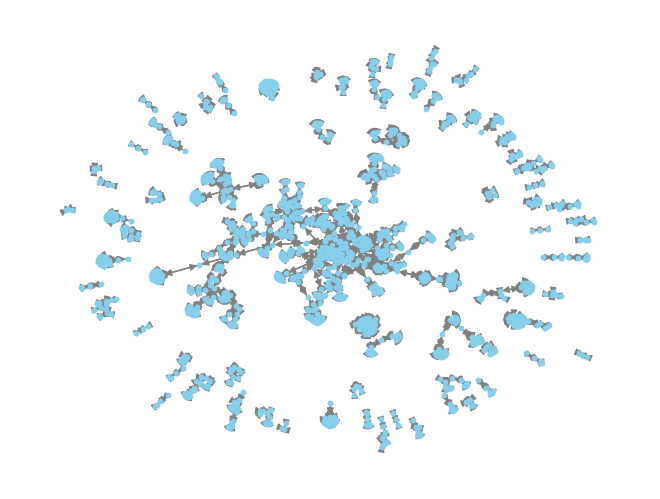

In [228]:
g_nx = to_networkx(data_undirected)

# Visualize the graph using NetworkX
pos = nx.spring_layout(g_nx)
nx.draw(g_nx, pos, with_labels=False, node_color='skyblue', font_weight='bold', font_color='black', node_size=10, edge_color='gray')

# Show the plot
plt.show()

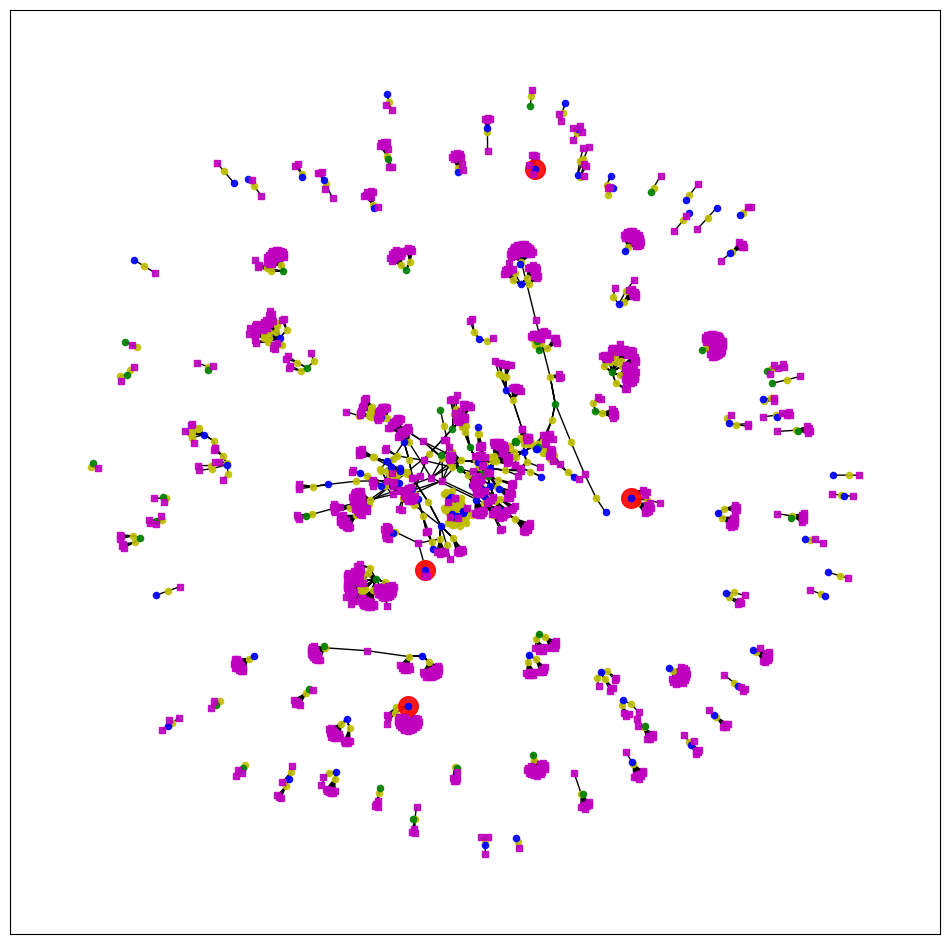

In [85]:
G = nx.MultiDiGraph()

ag_list = []
sgt_list = []
sgf_list = []
sgn_list = []
eg_list = []

for i, row in df_article_sorted.iterrows():
    G.add_node(f"{i}_a", node_type='article', x=row.to_numpy().astype(np.float32))
    ag_list.append(f"{i}_a")
for i, row in df_sources_mixte_sorted.iterrows():
    G.add_node(f"{i}_s", node_type='source', x=row.to_numpy().astype(np.float32))
    if y[i] == 1:
        sgf_list.append(f"{i}_s")
    if y[i] == 0:
        sgt_list.append(f"{i}_s")
    else:
        sgn_list.append(f"{i}_s")
for i, row in df_test_event_sorted_temp.iterrows():
    G.add_node(f"{i}_e", node_type='event', x=row.to_numpy().astype(np.float32))
    eg_list.append(f"{i}_e")

def append_suffix_mentionne(element, row_index):
    if row_index == 0:
        return str(element) + '_e'
    elif row_index == 1:
        return str(element) + '_a'
   
def append_suffix_edge_est_source_de(element, row_index):
    if row_index == 0:
        return str(element) + '_s'
    elif row_index == 1:
        return str(element) + '_a'
   
edge_mentionné_appended = np.vectorize(append_suffix_mentionne)(edge_mentionné, np.indices(edge_mentionné.shape)[0])
edge_est_source_de_appended = np.vectorize(append_suffix_edge_est_source_de)(edge_est_source_de, np.indices(edge_est_source_de.shape)[0])


G.add_edges_from(edge_mentionné_appended.transpose())
G.add_edges_from(edge_est_source_de_appended.transpose())

isolated_nodes = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(isolated_nodes)

G = G.to_undirected()

pos = nx.spring_layout(G)

plt.figure(figsize=(12,12))

nx.draw_networkx_edges(G, pos)

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in ag_list if x in G.nodes],
        node_size = 20,
        node_color = "y",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in sgf_list if x in G.nodes],
        node_size = 200,
        node_color = "r",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in sgt_list if x in G.nodes],
        node_size = 20,
        node_color = "g",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in sgn_list if x in G.nodes],
        node_size = 20,
        node_color = "b",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in eg_list if x in G.nodes],
        node_size = 20,
        node_color = 'm',
        node_shape = 's',
        alpha=0.9,
       )

plt.show()

In [57]:
edge_mentionné_appended.transpose()

array([['0_e', '464_a'],
       ['0_e', '879_a'],
       ['1_e', '337_a'],
       ...,
       ['1316_e', '1395_a'],
       ['1317_e', '1395_a'],
       ['1318_e', '1395_a']], dtype='<U6')

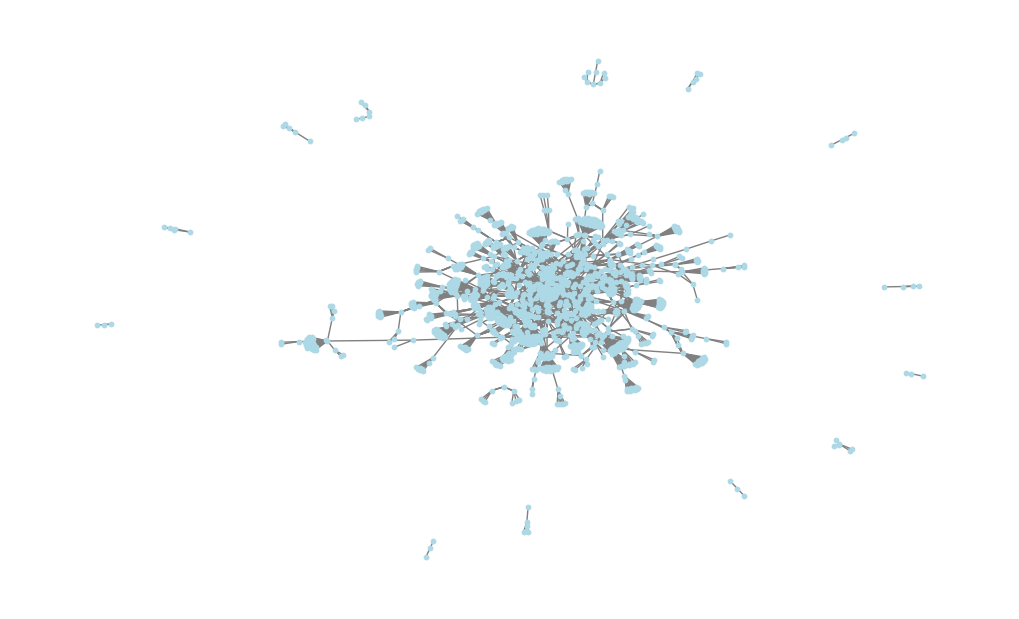

In [35]:
G = nx.MultiDiGraph()

# Add nodes with types and features
for i, row in df_article_sorted.iterrows():
    G.add_node(f"{i}_a", node_type='article', x=row.to_numpy().astype(np.float32))
for i, row in df_sources_mixte_sorted.iterrows():
    G.add_node(f"{i}_s", node_type='source', x=row.to_numpy().astype(np.float32))
for i, row in df_test_event_sorted_temp.iterrows():
    G.add_node(f"{i}_e", node_type='event', x=row.to_numpy().astype(np.float32))

# Add edges with types and features (if applicable)
G.add_edges_from(edge_mentionné.transpose(), edge_type='mentionne')
G.add_edges_from(edge_est_source_de.transpose(), edge_type='est_source_de')

# Remove isolated nodes
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(isolated_nodes)

# Convert to undirected (if needed)
G_undirected = G.to_undirected()

plt.figure(figsize=(10, 6))  # Adjust layout size
nx.draw(G_undirected, with_labels=False, node_color='lightblue', edge_color='gray', node_size=10)
plt.show()

In [ ]:
#TODO
# think of a way to properly display the graph (compress the graph, to reduce the number of nodes)
# scale to the whole month
# put features

### Creating a model

In [12]:
data['source'].y.value_counts(dropna = False)

is_fake
NaN    13300
0.0     1107
1.0       35
Name: count, dtype: int64

In [24]:
data.metadata()

(['article', 'source', 'event'],
 [('event', 'mentionné', 'article'), ('source', 'est_source_de', 'article')])

In [25]:
# from torch_geometric.nn import Linear, SAGEConv, Sequential, to_hetero, GCNConv
# import torch.nn.functional as F
# from torch.nn import ReLU
# #
# # class GNN(torch.nn.Module):
# #     def __init__(self, hidden_channels, out_channels):
# #         super().__init__()
# #         self.conv1 = SAGEConv((-1, -1), hidden_channels)
# #         self.conv2 = SAGEConv((-1, -1), out_channels)

# #     def forward(self, x, edge_index):
# #         x = self.conv1(x, edge_index)
# #         x = F.relu(x)
# #         x = self.conv2(x, edge_index)
# #         return x

# model = Sequential('x, edge_index', [
#     (GCNConv((-1, -1), 64), 'x, edge_index -> x'),
#     ReLU(inplace=True),
#     (GCNConv((-1, -1), 64), 'x, edge_index -> x'),
#     ReLU(inplace=True),
#     (Linear(-1, 2), 'x -> x'),
# ])


# # model = GNN(hidden_channels=64, out_channels=2)
# model = to_hetero(model, data.metadata(), aggr='sum')

TypeError: '>' not supported between instances of 'tuple' and 'int'

In [ ]:
train_input_nodes = ('sources', data['paper'].train_mask)
val_input_nodes = ('paper', data['paper'].val_mask)
kwargs = {'batch_size': 32 #, 'num_workers': 6, 'persistent_workers': True
          }

In [ ]:
from torch_geometric.nn import HANConv
import torch.nn.functional as F

class HANForGraphClassif(torch.nn.Module):
    def __init__(self, in_channels: int=300, hidden_channels: int=300,
              out_channels: int=300, n_heads=8, metadata=None):
        super(HANForGraphClassif, self).__init__()
        torch.manual_seed(12345)
        self.han_conv_0 = HANConv(in_channels=in_channels,
                               hidden_channels=in_channels,
                               out_channels=hidden_channels,
                               heads=n_heads,
                               metadata=metadata)
        if out_channels:
            input_lin_dim = out_channels
        else:
            input_lin_dim = hidden_channels
        self.lin = torch.nn.Linear(input_lin_dim, 2)
 
    def forward(self, x_dict, edge_index_dict):

        x = self.han_conv_0(x_dict, edge_index_dict)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [58]:
data.edge_index_dict.keys()

dict_keys([('event', 'mentionne', 'article'), ('source', 'est_source_de', 'article')])

In [61]:
data[('event', 'mentionne', 'article')].edge_index

tensor([[   0,    0,    1,  ..., 1316, 1317, 1318],
        [ 464,  879,  337,  ..., 1395, 1395, 1395]])

In [68]:
len(data['source'].x)

14442

In [ ]:
import torch
from torch_geometric.data import Data

# Assuming you have 'data' as your PyTorch Geometric Data object

# Initialize a list to store the nodes that are not isolated
remaining_nodes = []

# Iterate through each node in the graph
for i in range(data.num_nodes):
    # Check if the node has at least one neighbor
    if any(i in data[j].edge_index[0] or i in data[j].edge_index[1] for j in data.edge_index_dict.keys()):
        # Add the node to the list of remaining nodes
        remaining_nodes.append(i)

# Filter the edges to keep only those that involve remaining nodes
remaining_edges = []
for j in data.edge_index_dict.keys():
    edge_index = data[j].edge_index
    remaining_edges.append((edge_index[:, (edge_index[0] != edge_index[1]).nonzero(as_tuple=False)].t()))

# Create a new data object with remaining nodes and edges
new_data = Data()
new_data.num_nodes = len(remaining_nodes)
new_data.edge_index_dict = {}
for idx, edge_index in enumerate(remaining_edges):
    new_data.edge_index_dict[idx] = edge_index
    new_data.num_edges += edge_index.size(1)

# Output the number of isolated nodes
print("Number of isolated nodes:", data.num_nodes - len(remaining_nodes))

# Now 'new_data' contains the graph with isolated nodes removed


### Creating another model

In [29]:

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear



class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)
    def forward(self, x_dict, edge_index_dict):
        
        for node_type, x in x_dict.items():
            # print(self.lin_dict[node_type].weight)
            # print(x)
            # print(self.lin_dict[node_type](x))
            x_dict[node_type] =  self.lin_dict[node_type](x).relu_()
        
        for conv in self.convs:
            print("hi2")
            # print(x_dict)
            # print(edge_index_dict)
            print(x_dict.keys())
            print(conv)
            x_dict = conv(x_dict, edge_index_dict)
        print(x_dict.keys())
        return self.lin(x_dict['source'])


model = HGT(hidden_channels=64, out_channels=2, num_heads=2, num_layers=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['source'].train_mask
    loss = F.cross_entropy(out[mask], data['source'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask','test_mask']:
        mask = data['source'][split]
        acc = (pred[mask] == data['source'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 11):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f' Test: {test_acc:.4f}')

hi2
dict_keys(['article', 'source', 'event'])
HGTConv(-1, 64, heads=2)
dict_keys(['article'])


KeyError: 'source'

In [95]:
import os.path as osp


import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import HGTConv, Linear


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
datatest = dataset[0]

Extracting data\mag\raw\mag.zip
Extracting data\mag\raw\mag_metapath2vec_emb.zip
Processing...
Done!


### Another one

In [136]:
from torch_geometric.nn import HEATConv
import torch
import torch.nn as nn

class HEAT(nn.Module):
    def __init__(self, in_channels,
                 out_channels: int, hidden_channels=16, heads=2, num_node_types = 3, num_edge_types = 2, edge_type_emb_dim = 1, edge_dim = 1, edge_attr_emb_dim = 1):
        super().__init__()
        self.heat_conv = HEATConv(in_channels, hidden_channels, heads=heads,dropout=0.6, metadata=data.metadata(),num_node_types=num_node_types, num_edge_types=num_edge_types, edge_type_emb_dim=edge_type_emb_dim, edge_dim=edge_dim, edge_attr_emb_dim=edge_attr_emb_dim)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict, node_types, edge_types):
        out = self.heat_conv(x_dict, edge_index_dict, edge_attr = edge_attr_dict, node_type = node_types, edge_type = edge_types)
        out = self.lin(out['source'])
        return out


model = HEAT(in_channels=-1, out_channels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict, data.node_types, data.edge_types)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict, data.node_types, data.edge_types)
    loss = F.cross_entropy(out, data['source'].y)
    loss.backward()
    optimizer.step()
    return float(loss)

AttributeError: 'dict' object has no attribute 'size'